# W05 · Advanced CNNs, Data Augmentation & Transfer Learning

This notebook walks through an end-to-end computer vision workflow using the Kaggle **Dogs vs. Cats** dataset.You will download the data programmatically, prepare efficient `tf.data` pipelines with normalization and augmentation,train a VGG16-based classifier for feature extraction, and progressively fine-tune the network for higher accuracy.


## Learning objectives

* Authenticate with Kaggle and automate dataset downloads directly from a notebook.
* Structure image datasets for TensorFlow pipelines and apply normalization plus on-the-fly augmentation.
* Leverage `notebooks.dl_utils` utilities to build performant training `tf.data` inputs.
* Use a pre-trained VGG16 network as a fixed feature extractor and train a custom classifier head.
* Experiment with multiple fine-tuning strategies to adapt the convolutional base.


> **References**  > * `Training a convnet from scratch on a small dataset.ipynb` — baseline augmentation ideas.  > * `2- pretrained convnet.ipynb` — feature extraction vs. fine-tuning comparisons.  > * `dataset_api_kaggle.ipynb` — Kaggle authentication and API usage patterns.


## Environment & dataset setup

Follow the steps below before running any training code:

1. Install the Kaggle CLI (once per environment).
2. Copy the provided `kaggle.json` credentials into `~/.kaggle/` with restricted permissions.
3. Use the new `dl_utils.data.download_kaggle_competition` helper to fetch and extract the **Dogs vs. Cats** files.
4. Inspect the extracted archives and build TensorFlow datasets from the raw images.


In [1]:
# Install kaggle if it's not already present in the runtime
%pip install -q kaggle

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from __future__ import annotations

import json
import os
from pathlib import Path
import shutil
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from dl_utils import data as data_utils


In [2]:
# Directory layout
PROJECT_ROOT = Path.cwd()
DATA_ROOT = PROJECT_ROOT / "data" / "dogs-vs-cats"
ARCHIVE_DIR = DATA_ROOT / "archives"
RAW_DIR = DATA_ROOT / "raw"

# Training configuration
SEED = 1337
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.15  # remaining 0.15 will be used as a hold-out test set
SHUFFLE_BUFFER = 2048

DATA_ROOT.mkdir(parents=True, exist_ok=True)
ARCHIVE_DIR.mkdir(parents=True, exist_ok=True)
RAW_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_ROOT}")

Project root: a:\BRAND NEW START\Ongoing\Sep. 2025\Deep Learning\notebooks
Data directory: a:\BRAND NEW START\Ongoing\Sep. 2025\Deep Learning\notebooks\data\dogs-vs-cats


In [3]:
# Configure Kaggle credentials
kaggle_config_src = PROJECT_ROOT / "kaggle.json"
kaggle_config_dst = Path.home() / ".kaggle" / "kaggle.json"

if not kaggle_config_src.exists():
    raise FileNotFoundError("kaggle.json not found inside the notebooks/ directory")

kaggle_config_dst.parent.mkdir(parents=True, exist_ok=True)
shutil.copy2(kaggle_config_src, kaggle_config_dst)
os.chmod(kaggle_config_dst, 0o600)

print(f"Kaggle credentials copied to {kaggle_config_dst}")

Kaggle credentials copied to C:\Users\Metwalli\.kaggle\kaggle.json


In [4]:
# Download and extract the Kaggle Dogs vs. Cats competition files
COMPETITION = "dogs-vs-cats"
archives_path = data_utils.download_kaggle_competition(
    COMPETITION,
    target_dir=ARCHIVE_DIR,
    unzip=True,
)

print(f"Competition files downloaded to: {archives_path}")
print("Available archives:")
for item in sorted(archives_path.iterdir()):
    print(" •", item.name)


Competition files downloaded to: a:\BRAND NEW START\Ongoing\Sep. 2025\Deep Learning\notebooks\data\dogs-vs-cats\archives
Available archives:
 • dogs-vs-cats.zip
 • sampleSubmission.csv
 • test1.zip
 • train.zip


In [17]:
# Extract nested archives (train.zip and test1.zip)
TRAIN_ARCHIVE = ARCHIVE_DIR / "train.zip"
TEST_ARCHIVE = ARCHIVE_DIR / "test1.zip"
TRAIN_EXTRACT_DIR = RAW_DIR / "train"/"train"
TEST_EXTRACT_DIR = RAW_DIR / "test1"/"test1"

for archive, target in [
    (TRAIN_ARCHIVE, TRAIN_EXTRACT_DIR),
    (TEST_ARCHIVE, TEST_EXTRACT_DIR),
]:
    if archive.exists():
        target.mkdir(parents=True, exist_ok=True)
        if not any(target.iterdir()):
            with zipfile.ZipFile(archive) as zf:
                zf.extractall(target)
            print(f"Extracted {archive.name} -> {target}")
        else:
            print(f"Skipping extraction for {archive.name}; files already present.")
    else:
        print(f"Archive {archive} is missing. Ensure the Kaggle download succeeded.")


Skipping extraction for train.zip; files already present.
Skipping extraction for test1.zip; files already present.


In [18]:
# Count images and prepare labels
train_image_paths = sorted(TRAIN_EXTRACT_DIR.glob("*.jpg"))
print(f"Total train images: {len(train_image_paths):,}")

labels = np.array([1 if path.name.startswith("dog") else 0 for path in train_image_paths], dtype=np.int32)
class_names = ["cat", "dog"]
print({name: int((labels == idx).sum()) for idx, name in enumerate(class_names)})


Total train images: 25,000
{'cat': 12500, 'dog': 12500}


## Building a normalized & augmented `tf.data` pipeline

We will split the dataset into **70% training**, **15% validation**, and **15% testing**. Images are decoded from disk,
resized to 224×224, normalized to `[0, 1]`, and augmented on-the-fly for the training split. The helper
`data_utils.prepare_for_training` encapsulates the common caching, shuffling, batching, and prefetching steps.


In [19]:
# Train/validation/test split using NumPy for reproducibility
rng = np.random.default_rng(SEED)
indices = np.arange(len(train_image_paths))
rng.shuffle(indices)

train_end = int(len(indices) * TRAIN_SPLIT)
val_end = int(len(indices) * (TRAIN_SPLIT + VAL_SPLIT))

split_indices = {
    "train": indices[:train_end],
    "val": indices[train_end:val_end],
    "test": indices[val_end:],
}

split_paths = {
    split: np.array([str(train_image_paths[i]) for i in split_idx])
    for split, split_idx in split_indices.items()
}

split_labels = {
    split: labels[split_indices[split]]
    for split in split_indices
}

for split in split_paths:
    print(f"{split.title():<5}: {len(split_paths[split]):,} images")


Train: 17,500 images
Val  : 3,750 images
Test : 3,750 images


In [20]:
# Low-level preprocessing functions
def load_and_resize(path: tf.Tensor, label: tf.Tensor) -> tuple[tf.Tensor, tf.Tensor]:
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE, antialias=True)
    image = tf.cast(image, tf.float32)
    label = tf.cast(label, tf.float32)
    return image, tf.expand_dims(label, axis=-1)


normalizer = layers.Rescaling(1.0 / 255.0, name="rescale_01")


def normalize(image: tf.Tensor, label: tf.Tensor) -> tuple[tf.Tensor, tf.Tensor]:
    return normalizer(image), label


augmenter = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.08),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
    ],
    name="augmenter",
)


def augment(image: tf.Tensor, label: tf.Tensor) -> tuple[tf.Tensor, tf.Tensor]:
    return augmenter(image, training=True), label


def make_dataset(paths: np.ndarray, labels_arr: np.ndarray) -> tf.data.Dataset:
    ds = tf.data.Dataset.from_tensor_slices((paths, labels_arr))
    return ds.map(load_and_resize, num_parallel_calls=tf.data.AUTOTUNE)


train_raw = make_dataset(split_paths["train"], split_labels["train"])
val_raw = make_dataset(split_paths["val"], split_labels["val"])
test_raw = make_dataset(split_paths["test"], split_labels["test"])

train_ds = data_utils.prepare_for_training(
    train_raw.map(normalize, num_parallel_calls=tf.data.AUTOTUNE),
    batch_size=BATCH_SIZE,
    shuffle_buffer=SHUFFLE_BUFFER,
    augment_fn=augment,
)

val_ds = data_utils.prepare_for_training(
    val_raw.map(normalize, num_parallel_calls=tf.data.AUTOTUNE),
    batch_size=BATCH_SIZE,
    shuffle_buffer=None,
)

test_ds = data_utils.prepare_for_training(
    test_raw.map(normalize, num_parallel_calls=tf.data.AUTOTUNE),
    batch_size=BATCH_SIZE,
    shuffle_buffer=None,
)


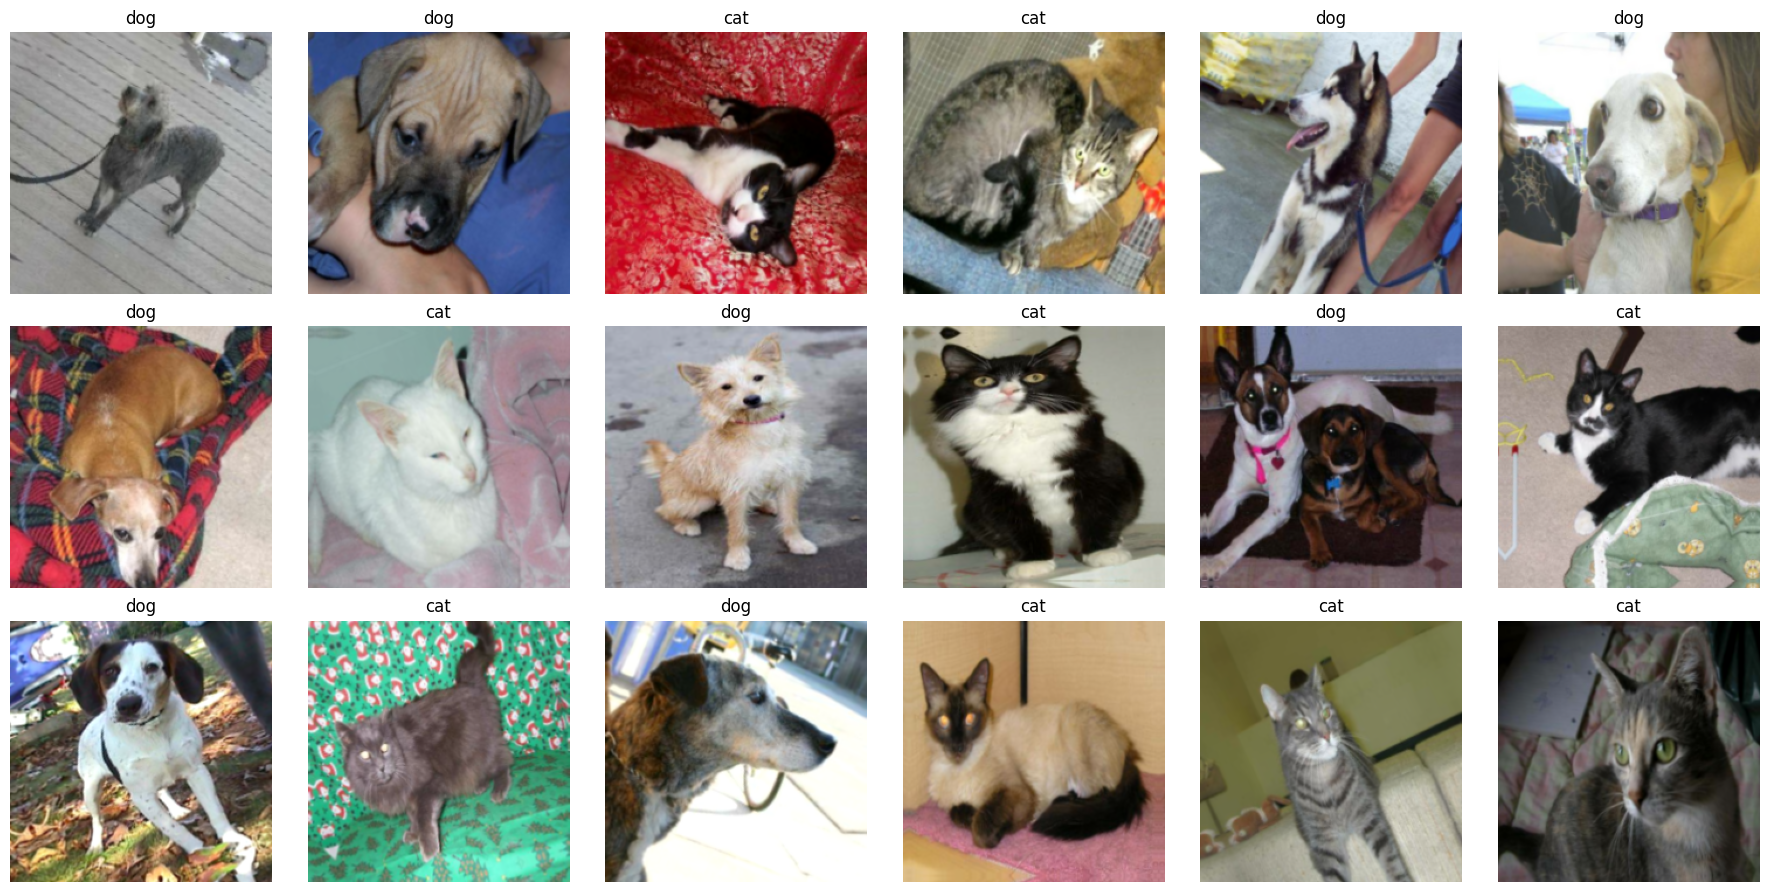

In [21]:
# Visualize a batch of augmented training images
batch_images, batch_labels = next(iter(train_ds.take(1)))
fig, axes = plt.subplots(3, 6, figsize=(18, 9))
for ax, image, label in zip(axes.flat, batch_images, batch_labels):
    ax.imshow(np.clip(image.numpy(), 0, 1))
    ax.set_title(class_names[int(label.numpy().squeeze())])
    ax.axis("off")
plt.tight_layout()


## Feature extraction with VGG16

The VGG16 convolutional base (pre-trained on ImageNet) is loaded without its fully-connected classifier.
We freeze all convolutional layers and train a lightweight classification head on top of the frozen features.
A `preprocess_input` layer is included inside the model to keep the dataset pipeline agnostic to VGG-specific
normalization.


In [ ]:
base_model = keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,),
)
base_model.trainable = False

preprocess = layers.Lambda(
    keras.applications.vgg16.preprocess_input,
    name="vgg16_preprocess",
)

def build_model(trainable_base: bool = False, learning_rate: float = 1e-4) -> keras.Model:
    base_model.trainable = trainable_base
    inputs = keras.Input(shape=IMG_SIZE + (3,), name="input_image")
    x = preprocess(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid", name="predictions")(x)
    model = keras.Model(inputs, outputs, name="dogs_vs_cats_vgg16")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.BinaryAccuracy(name="accuracy"),
            keras.metrics.AUC(name="auc"),
        ],
    )
    return model

model = build_model(trainable_base=False, learning_rate=1e-3)
model.summary()


In [ ]:
initial_epochs = 5
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=3,
        restore_best_weights=True,
    )
]

history_feature_extractor = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs,
    callbacks=callbacks,
)


In [ ]:
# Plot training history for the frozen-base stage
def plot_history(history: keras.callbacks.History, label: str) -> None:
    metrics = ["loss", "accuracy", "auc"]
    fig, axes = plt.subplots(1, len(metrics), figsize=(18, 4))
    for ax, metric in zip(axes, metrics):
        ax.plot(history.history[metric], label=f"train {metric}")
        ax.plot(history.history[f"val_{metric}"], label=f"val {metric}")
        ax.set_title(f"{label} · {metric}")
        ax.set_xlabel("Epoch")
        ax.legend()
    plt.tight_layout()

plot_history(history_feature_extractor, label="Frozen VGG16")


## Fine-tuning strategy 1 · Unfreeze the final convolutional block

With the classifier head trained, we can adapt the deeper convolutional filters.
Here we unfreeze **Block 5** of VGG16 (the last convolutional block) and continue training with a
smaller learning rate to avoid catastrophic forgetting.


In [ ]:
# Unfreeze the last convolutional block (Block 5)
block5_start = 15  # index at which block5_conv1 appears in the VGG16 architecture
for layer in base_model.layers[:block5_start]:
    layer.trainable = False
for layer in base_model.layers[block5_start:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=[
        keras.metrics.BinaryAccuracy(name="accuracy"),
        keras.metrics.AUC(name="auc"),
    ],
)

fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs

history_block5 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history_feature_extractor.epoch[-1] + 1,
    callbacks=callbacks,
)


## Fine-tuning strategy 2 · Gradual unfreezing of the entire base

After adapting the final block, we can slowly unfreeze the rest of VGG16. Lower the learning rate further
and optionally use an exponential decay schedule. Monitor validation performance closely to avoid overfitting.


In [ ]:
# Unfreeze the entire base for a final polishing stage
base_model.trainable = True
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-6),
    loss="binary_crossentropy",
    metrics=[
        keras.metrics.BinaryAccuracy(name="accuracy"),
        keras.metrics.AUC(name="auc"),
    ],
)

history_full = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs + 5,
    initial_epoch=history_block5.epoch[-1] + 1,
    callbacks=callbacks,
)


## Evaluation on the hold-out test set

Use the test split to obtain an unbiased estimate of the model's generalization performance.
This includes aggregate metrics and optional qualitative inspection of predictions.


In [ ]:
test_metrics = model.evaluate(test_ds, return_dict=True)
print(json.dumps(test_metrics, indent=2))


In [ ]:
# Visualize a few predictions on the test set
probabilities = []
labels_true = []
images = []
for batch_images, batch_labels in test_ds.take(5):
    preds = model.predict(batch_images)
    probabilities.extend(np.asarray(preds).squeeze().tolist())
    labels_true.extend(batch_labels.numpy().squeeze().tolist())
    images.extend(batch_images.numpy())

fig, axes = plt.subplots(3, 5, figsize=(20, 12))
for ax, image, prob, label in zip(axes.flat, images, probabilities, labels_true):
    ax.imshow(np.clip(image, 0, 1))
    pred_label = class_names[int(prob >= 0.5)]
    ax.set_title(f"Pred: {pred_label} ({prob:.2f}) True: {class_names[int(label)]}")
    ax.axis("off")
plt.tight_layout()
